In [ ]:
#!/usr/bin/env python
# coding: utf-8

#  3D Pull Apart Model. Original model for Patrice Rey, Luke Hardiman and Trisan Salles, translated to UWGeo by Romain Beucher
#  Revisited by Patrice Rey Feb 2019

import UWGeodynamics as GEO


# In[2]:


u = GEO.UnitRegistry


# In[3]:


# Characteristic values of the system
velocity = 1.0 * u.centimeter / u.year
model_length = 256e3 * u.meter
model_width = 256e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT


# # Model Geometry

# In[4]:

resolution = (32, 32, 16)
Model = GEO.Model(elementRes=resolution,
                  minCoord=(0. * u.kilometer, 0. * u.kilometer, -120. * u.kilometer),
                  maxCoord=(256. * u.kilometer, 256. * u.kilometer, 8. * u.kilometer),
                  gravity=(0.0, 0.0, -9.81 * u.meter / u.second**2))



Model.outputDir="LPT200_HR4"


# In[6]:


Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second
Model.stressLimiter = 300. * u.megapascal



In [2]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)


# In[8]:


air        = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=2 * u.kilometer))
stickyAir  = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=air.bottom, bottom= 0 * u.kilometer))
uppercrust = Model.add_material(name="UpperCrust", shape=GEO.shapes.Layer(top=stickyAir.bottom, bottom=-16 * u.kilometer))
lowercrust = Model.add_material(name="Lower Crust", shape=GEO.shapes.Layer(top=uppercrust.bottom, bottom=-40 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=lowercrust.bottom, bottom=-100 * u.kilometer))
mantle     = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="Sediment")


air.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 1000. * u.joule / (u.kelvin * u.kilogram)


# ## Densities

# In[12]:


air.density         = 1. * u.kilogram / u.metre**3
stickyAir.density   = 1. * u.kilogram / u.metre**3
uppercrust.density  = GEO.LinearDensity(reference_density=2620. * u.kilogram / u.metre**3)
lowercrust.density  = GEO.LinearDensity(reference_density=2850. * u.kilogram / u.metre**3)
mantleLithosphere.density  = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.density      = GEO.LinearDensity(reference_density=3395. * u.kilogram / u.metre**3)
sediment.density = 2300. * u.kilogram / u.metre**3


uppercrust.radiogenicHeatProd = 1.2 * u.microwatt / u.meter**3
lowercrust.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.0
mantle.radiogenicHeatProd = 0.0
sediment.radiogenicHeatProd = 0.6 * u.microwatt / u.meter**3


# ## Viscosities

# In[14]:


rh = GEO.ViscousCreepRegistry()

air.viscosity                = 1e18 * u.pascal * u.second
stickyAir.viscosity          = 1e19 * u.pascal * u.second
uppercrust.viscosity         = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
lowercrust.viscosity         = rh.Dry_Maryland_Diabase_Dislocation_Mackwell_et_al_1998
mantleLithosphere.viscosity  = 5.0 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1990
mantle.viscosity             = rh.Dry_Olivine_Dislocation_Karato_and_Wu_1990
sediment.viscosity           = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995


# ## Plasticities

# In[15]:


pl = GEO.PlasticityRegistry()

uppercrust.plasticity = pl.Rey_and_Muller_2010_UpperCrust
lowercrust.plasticity = pl.Rey_and_Muller_2010_LowerCrust
mantleLithosphere.plasticity  = pl.Rey_and_Muller_2010_LithosphericMantle
sediment.plasticity           = pl.Huismans_et_al_2011_Crust



# ## Passive Tracers

# In[16]:


import numpy as np

xp = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 384)
yp = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), 256)

xp, yp = np.meshgrid(xp, yp)
xp = xp.flatten()
yp = yp.flatten()
zp = np.zeros(xp.shape)

surface_tracers = Model.add_passive_tracers(name="Surface Tracers", vertices=[xp, yp, zp], zOnly=True)
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[xp, yp, zp+GEO.nd(mantleLithosphere.top)], zOnly=True)
Lab_tracers = Model.add_passive_tracers(name="Lab", vertices=[xp,yp,-90.*u.kilometer])


In [4]:
Model.set_temperatureBCs(top=293.15 * u.degK,
                         bottom=1603.15 * u.degK)


# ## Velocity Boundary Conditions

# In[18]:


vA = GEO.nd(-1.28 * u.centimeter / u.year)
vB = GEO.nd( 1.28 * u.centimeter / u.year)
yA = GEO.nd(90. * u.kilometer)
yB = GEO.nd(115 * u.kilometer)

right_condition = [(Model.y <= yA, vA),
                   (Model.y >= yB, vB),
                   (True, (vB -vA) / (yB - yA) * (Model.y - yA) + vA)]

yA = GEO.nd(140. * u.kilometer)
yB = GEO.nd(165 * u.kilometer)

left_condition = [(Model.y <= yA, vA),
                   (Model.y >= yB, vB),
                   (True, (vB -vA) / (yB - yA) * (Model.y - yA) + vA)]

left_condition = GEO.uw.function.branching.conditional(left_condition)
right_condition = GEO.uw.function.branching.conditional(right_condition)

Model.set_velocityBCs(left=[left_condition, None,  None],
                      right=[right_condition, None,  None],
                      front=[None, 0., None],
                      back=[None, 0., None],
                      bottom=GEO.LecodeIsostasy(
                          reference_mat=mantle,
                          average=True),
                      order_wall_conditions=["top", "front", "back", "bottom", "left", "right"])

# # Initial Damage

# In[19]:


DamageFault1Shape = GEO.shapes.Box(minX=20. * u.kilometer, maxX=89. * u.kilometer,
                                   minY=145. * u.kilometer, maxY=159. * u.kilometer,
                                   bottom=-40. * u.kilometer, top=-5. * u.kilometer)

DamageFault2Shape = GEO.shapes.Box(minX=167. * u.kilometer, maxX=236. * u.kilometer,
                                   minY=97. * u.kilometer, maxY=111. * u.kilometer,
                                   bottom=-40. * u.kilometer, top=-5. * u.kilometer)

DamageFault3Shape = GEO.shapes.Box(minX=20. * u.kilometer, maxX=89. * u.kilometer,
                                   minY=145. * u.kilometer, maxY=159. * u.kilometer,
                                   bottom=-100. * u.kilometer, top=-40. * u.kilometer)

DamageFault4Shape = GEO.shapes.Box(minX=167. * u.kilometer, maxX=236. * u.kilometer,
                                   minY=97. * u.kilometer, maxY=111. * u.kilometer,
                                   bottom=-100. * u.kilometer, top=-40. * u.kilometer)


In [5]:
import numpy
import underworld.function as fn

coord = fn.input()

A = (coord[1] - GEO.nd( 145.0 * u.kilometer)) / GEO.nd( 14.0 * u.kilometer)
B = (coord[0] - GEO.nd(20.0 * u.kilometer)) / GEO.nd(69.0 * u.kilometer)
fault1 = fn.math.sin(np.pi*A) * fn.math.sin(np.pi*B)

A = (coord[1] - GEO.nd( 97.0 * u.kilometer)) / GEO.nd( 14.0 * u.kilometer)
B = (coord[0] - GEO.nd( 167.0 * u.kilometer)) / GEO.nd(69.0 * u.kilometer)
fault2 = fn.math.sin(np.pi*A) * fn.math.sin(np.pi*B)

conditions = [(DamageFault1Shape.fn, fault1),
              (DamageFault2Shape.fn, fault2),
              (DamageFault3Shape.fn, fault1),
              (DamageFault4Shape.fn, fault2),
              (True, 0.0)]

DamageFn = fn.branching.conditional(conditions)
Model.plasticStrain.data[...] = DamageFn.evaluate(Model.swarm)
Model.plasticStrain.data[...] *= 1.0 * np.random.rand(*Model.plasticStrain.data.shape)
# Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[stickyAir.index, air.index], sedimentIndex=sediment.index,
#                                           XML="ressources/badlands.xml", resolution=1 * u.kilometer,
#                                           checkpoint_interval=0.05 * u.megayears)

Model.init_model()
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2
GEO.rcParams["nonlinear.tolerance"] = 1e-2
GEO.rcParams["popcontrol.particles.per.cell.3D"] = 60
GEO.rcParams["swarm.particles.per.cell.3D"] = 60

Model.solver.options.set_inner_method = "mg"
Model.solver.options.levels = 5
Model.solver.options.A11.mg_coarse_pc_factor_mat_solver_type = "mumps"
Model.solver.options.A11.mg_coarse_pc_type = "hypre"
Model.solver.options.A11.mg_coarse_ksp_type = "cg"
#Model.solver.options.A11.ksp_monitor = "ascii"
Model.solver.options.A11.ksp_rtol = "1e-6"
#Model.solver.options.scr.ksp_monitor_true_residual = "ascii"
#Model.solver.options.scr.ksp_converged_reason = "ascii"
Model.solver.options.scr.ksp_rtol = "1e-5"
Model.solver.options.main.remove_constant_pressure_null_space = True
#Model.solver.options.A11.ksp_converged_reason = "ascii"
Model.solver.options.main.options_left = ""
Model.solver.options.main.log_summary = ""
# Model.run_for(10. * u.megayears, restartStep=91,   checkpoint_interval=0.05 * u.megayears)
                                                                                              

In [ ]:
Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.temperature, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

In [ ]:
Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.plasticStrain, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.temperature, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.plasticStrain, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

Fig = glucifer.Figure(figsize=(1200,400), title="Velocity (cm/yr)", quality=2)
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.show()

Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.pressureField, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

## Solver, Model init

In [6]:
import matplotlib.pyplot as plt

In [7]:
mohoT = Model.temperature.evaluate(moho_tracers.swarm)[:,0].mean()
print("Moho Temperature = ", GEO.Dimensionalize(mohoT, u.degC)) 
LabT = Model.temperature.evaluate(Lab_tracers.swarm)[:,0].mean()
print("Lab Temperature = ", GEO.Dimensionalize(LabT, u.degC)) 



('Moho Temperature = ', <Quantity(701.044869435, 'degC')>)
('Lab Temperature = ', <Quantity(1094.14319553, 'degC')>)


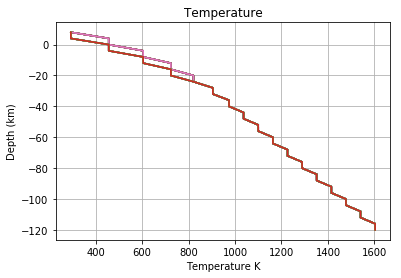

In [8]:
MyTemperatureField=(Model.temperature.data[:] * GEO.Dimensionalize(1.0, u.degK)).magnitude 

TemperatureData=np.asarray(MyTemperatureField)
TemperatureDataShaped=TemperatureData.reshape(resolution[1]+1,resolution[0]+1,resolution[2]+1)

#Two profiles located at the left walls and the middle.
plt.plot(TemperatureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(TemperatureDataShaped[:, resolution[2]/2], np.linspace(Model.bottom,Model.top,resolution[1]+1))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Temperature K')
plt.ylabel('Depth (km)')
plt.title('Temperature')
plt.show()

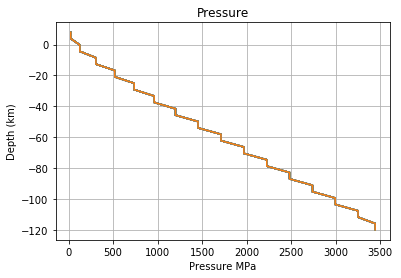

In [11]:
MyPressureField=(Model.pressureField.data[:] * GEO.Dimensionalize(1.0, u.megapascal)).magnitude 

PressureData=np.asarray(MyPressureField)
PressureDataShaped=PressureData.reshape(resolution[1],resolution[0],resolution[2])

#Two profiles located at the left walls and the middle.
plt.plot(PressureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(PressureDataShaped[:,resolution[2]/2], np.linspace(Model.bottom,Model.top,resolution[1]))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Pressure MPa')
plt.ylabel('Depth (km)')
plt.title('Pressure')
plt.show()



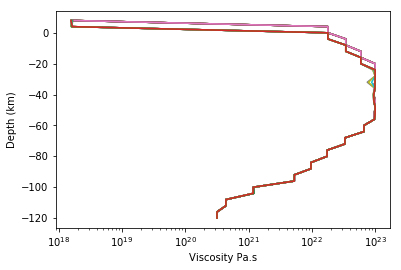

In [9]:
MyViscosityField=(Model.projViscosityField.data[:] * GEO.Dimensionalize(1.0, u.pascal * u.second)).magnitude 

ViscosityData=np.asarray(MyViscosityField)
ViscosityDataShaped=ViscosityData.reshape(resolution[1]+1,resolution[0]+1,resolution[2]+1)

#Two profiles located at the left walls and the middle.
plt.plot(ViscosityDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(ViscosityDataShaped[:,resolution[0]/2], np.linspace(Model.bottom,Model.top,resolution[1]+1))



## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
#plt.grid()
plt.xscale('log')
plt.xlabel('Viscosity Pa.s')
plt.ylabel('Depth (km)')
## plt.title('Viscosity')
plt.show()



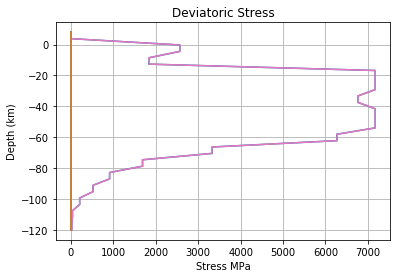

In [10]:
MyStressField=(Model.projStressField.data[:] * GEO.Dimensionalize(1.0, u.megapascal)).magnitude 

StressData=np.asarray(MyStressField)
StressDataShaped=StressData.reshape(resolution[1],resolution[0],resolution[2])

#Two profiles located at the left walls and the middle.

plt.plot(StressDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(StressDataShaped[:,resolution[0]/2], np.linspace(Model.bottom,Model.top,resolution[1]))


## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xlabel('Stress MPa')
plt.ylabel('Depth (km)')
plt.title('Deviatoric Stress')
plt.show()

In [ ]:
#Model.run_for(10.0 * u.megayears, checkpoint_interval=0.005 * u.megayears,restart_checkpoint=2)
